In [1]:
import zipfile
import os

# 本地文件路径
train_data = 'train.csv'
test_data = 'test.csv'
img_data = 'data.zip'

# 解压缩数据
with zipfile.ZipFile(img_data, 'r') as zip_ref:
    zip_ref.extractall('./')

# 如果需要，你可以在这里添加代码来读取 train.csv 和 test.csv 文件


FileNotFoundError: [Errno 2] No such file or directory: 'data.zip'

In [112]:

!ls

Assignment2.pdf
COMP5329 Assignment 2 - Code.ipynb
COMP5329S1A2Dataset
best_steps.pth
comp5329-a2-competition-114153.ipynb
googlenet.ipynb
googlenet_original.ipynb
multi-label-classification-competition-2024.zip
nltk_data
sample algorithm
test.ipynb


In [113]:
import nltk
from nltk.corpus import wordnet, stopwords
# List of NLTK resources you need
nltk_resources = ['omw-1.4', 'stopwords', 'wordnet']

# Function to download necessary NLTK resources
def download_nltk_resources(resources):
    for resource in resources:
        try:
            nltk.data.find(resource)
        except LookupError:
            nltk.download(resource, "/nltk_data/")  # Downloads the correct resource

# Download necessary resources
download_nltk_resources(nltk_resources)

# Now you can safely load stopwords and use wordnet
stop_words = set(stopwords.words('english'))
lemmatizer = nltk.stem.WordNetLemmatizer()


[nltk_data] Downloading package omw-1.4 to /nltk_data/...


OSError: [Errno 30] Read-only file system: '/nltk_data/'

In [4]:
import os
import re
import time
import torch
import gensim.downloader
import gensim.downloader as gensim_api
import numpy as np
import pandas as pd
import torch.nn as nn
import skimage.io as io
import matplotlib.pyplot as plt
from tqdm import tqdm
from io import StringIO
from torchvision import transforms, models
from torchvision import models
from collections import Counter
from sklearn.metrics import f1_score, precision_score, recall_score
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import warnings

warnings.filterwarnings("ignore")  # Ignore the warning of the sklearn version

In [5]:
# NLP 相关资源下载
nltk_resources = ['omw-1.4', 'stopwords', 'wordnet']
for resource in nltk_resources:
    try:
        nltk.data.find(f'tokenizers/{resource}')
    except LookupError:
        nltk.download(resource)

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/sugardady/nltk_data...
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sugardady/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sugardady/nltk_data...


In [21]:
# File path and the Global parameters
DIR = 'COMP5329S1A2Dataset'
TRAIN_CSV = os.path.join(DIR, "train.csv")
TEST_CSV = os.path.join(DIR, "test.csv")
IMAGE_DIR = os.path.join(DIR, "data")
TRAIN_VAL_PROP = 0.8
BATCH_SIZE = 32
SEED = 5329
LR = 0.001
MAX_EPOCH = 20
THRESHOLD = 0.3
NUM_CLASS = 18
device = "cuda" if torch.cuda.is_available() else "cpu"

# 下载并加载预训练的词向量模型
EMBEDDING_MODEL = gensim_api.load('glove-wiki-gigaword-50')

In [7]:
# Correct the error data item in the train data file
with open(TRAIN_CSV) as fp:
    data = fp.readlines()

data[4790] = data[4790].replace("/", "")
data[14716] = data[14716].replace("/", "")
data[14961] = data[14961].replace("/", "")
data[29895] = data[29895].replace("/", "")

# Write back
with open(TRAIN_CSV, 'w') as file:
    file.writelines(data)

In [8]:
# Set of stopwords
stop_words = set(stopwords.words('english'))

# Lemmatizer object
lemmatizer = WordNetLemmatizer()

# Set of word errors
word_error = {'baeball', 'basball', 'blackandwhite', 'bluewhite', 'checkerd', 'firehydrant','firsbee', 'fourwheeler', 'frisbe', 'frizbee', 'kiteboards', 'krispee','midswing', 'parasailers', 'skiboard', 'skii', 'skiies', 'surfboarder','surfboarding', 'tball', 'umbrells', 'windsurfs', 'deckered', 'rared','snowcovered'}
        
def caption_extract(caption):
    caption_in_word = []

    for sentence in caption:
        # Convert the caption to lowercase and remove non-alphabetic characters and replace with space
        sentence = sentence.lower()
        sentence = re.sub(r'[^A-Za-z]+', ' ', sentence)
        # Split the caption into a list of words
        words = sentence.split()

        # Remove stopwords and perform lemmatization
        filtered_words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]

        # Filter out words with errors
        correct_word = [word for word in filtered_words if not word in word_error]
        caption_in_word.append(correct_word)

    return caption_in_word


def process_captions(train_file_path, test_file_path):

    # Processing train captions
    with open(train_file_path) as train_file:
        # Preprocessing step to handle quotes inside the captions
        train_lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in train_file]
        train_caption = pd.read_csv(StringIO(''.join(train_lines)), escapechar="/")
        train_caption = train_caption.drop(columns='Caption').join(train_caption['Caption'].str.replace('\"', ''))

    # Processing test captions
    with open(test_file_path) as test_file:
        # Preprocessing step to handle quotes inside the captions
        test_lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in test_file]
        test_caption = pd.read_csv(StringIO(''.join(test_lines)), escapechar="/")
        test_caption = test_caption.drop(columns='Caption').join(test_caption['Caption'].str.replace('\"', ''))

    # Extracting main feature words from concatenated train and test captions
    caption = caption_extract(pd.concat([train_caption['Caption'], test_caption['Caption']], axis=0, ignore_index=True))

    # Finding the maximum length among all captions
    max_len = max(len(s) for s in caption)

    return caption, max_len


whole_caption, max_caption_len = process_captions(TRAIN_CSV, TEST_CSV)
# vector size of each word
embedding_dim = EMBEDDING_MODEL.vector_size

In [9]:
def create_word_model(caption):

    # Extract words from the caption
    word_list = [word for sentence in caption for word in sentence]

    # Count word occurrences in the caption
    word_counter = Counter(word_list)

    # Select the words with more than 1 appearance for the vocabulary set
    vocab_set = {word for word, count in word_counter.items() if count > 4}

    # Add the PAD and UNKNOWN to the vocabulary set
    vocab_set.update(['[PAD]', '[UNKNOWN]'])

    # Sort the vocabulary set
    vocab_list = sorted(vocab_set)

    # Create the word dictionary and embedding table based on the pre-trained word embedding model
    vocab_dictionary = {}
    embedding_table = []
    for i, word in enumerate(vocab_list):
        vocab_dictionary[word] = i
        # If the word is in the pre-trained word embedding model, add word embedding to the table
        if word in EMBEDDING_MODEL:
            embedding_table.append(EMBEDDING_MODEL[word])
        else:
            embedding_table.append([0] * embedding_dim)
    embedding_table = np.array(embedding_table)

    return vocab_dictionary, embedding_table


vocab_dict, emb_table = create_word_model(whole_caption)

In [10]:
def tokenizer(caption):

    tokenize = []
    # Extract main feature words from captions
    caption = caption_extract(caption)

    for item in caption:
        # Convert each word to its corresponding index in the vocabulary dictionary
        # If a word is not present in the dictionary, use the index for the [UNKNOWN] token
        temp = [vocab_dict[word] if word in vocab_dict else vocab_dict['[UNKNOWN]'] for word in item]
        if len(temp) < max_caption_len:
            # If the caption is shorter than the maximum length
            # Pad the caption with [PAD] tokens to make it of maximum length
            temp += [vocab_dict['[PAD]']] * (max_caption_len - len(temp))
        else:
            # Truncate the caption if it exceeds the maximum length
            temp = temp[:max_caption_len]
        tokenize.append(temp)

    return tokenize

In [11]:
class DataLoad(torch.utils.data.Dataset):

    def __init__(self, data_file, image, transform=None, text_csv=None):

        self.image_dir = image
        self.text_csv = text_csv
        self.transform = transform
        self.classes = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19]  # List of classes

        with open(data_file) as data_file:
            # Remove the 'Caption' column and join the 'Caption' values after removing quotes
            lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in data_file]
            dataframe = pd.read_csv(StringIO(''.join(lines)), escapechar="/")
            self.dataframe = dataframe.drop(columns='Caption').join(dataframe['Caption'].str.replace('\"', ''))

    def __len__(self):

        return self.dataframe.shape[0]

    def __getitem__(self, item):
  
        if torch.is_tensor(item):
            item.to_list()

        # Combine the image path with the image file name
        img_path = os.path.join(self.image_dir, self.dataframe.iloc[item, 0])
        img = io.imread(img_path)
        img_id = self.dataframe.iloc[item, 0]

        if not self.text_csv:
            img_caption = self.dataframe.iloc[item, 2]
            # Get the image labels and split them
            img_label = self.dataframe.iloc[item, 1].split(' ')
            # Convert labels to integers
            img_label = [int(x) for x in img_label]

            for i in range(len(img_label)):
                # One-hot encode and sum the image labels
                img_label[i] = [1 if cls == img_label[i] else 0 for cls in self.classes]
            img_label = sum(torch.tensor(img_label, dtype=torch.float))

            if self.transform:
                img = self.transform(img)

            sample = {'img': img, 'label': img_label, 'id': img_id, 'caption': img_caption}
        else:
            img_caption = self.dataframe.iloc[item, 1]
            if self.transform:
                img = self.transform(img)
            sample = {'img': img, 'id': img_id, 'caption': img_caption}

        return sample

In [12]:
# Image Pre-Processing
transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((256, 256)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(),
        transforms.RandomAffine(degrees=20, translate=(0.2, 0.2), scale=(0.5, 1.5),
                                shear=None,
                                fill=tuple(np.array(np.array([0.485, 0.456, 0.406]) * 255).astype(int).tolist())),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((256, 256)),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
}

dataset = DataLoad(data_file=TRAIN_CSV, image=IMAGE_DIR, transform=transforms['train'], text_csv=False)
test_dataset = DataLoad(data_file=TEST_CSV, image=IMAGE_DIR, transform=transforms['val'], text_csv=True)
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [int(TRAIN_VAL_PROP * len(dataset)),
                                                                     len(dataset) - (
                                                                         int(TRAIN_VAL_PROP * len(dataset)))])

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=8, shuffle=False, num_workers=0)

Image ID: 0.jpg
Caption: Woman in swim suit holding parasol on sunny day.


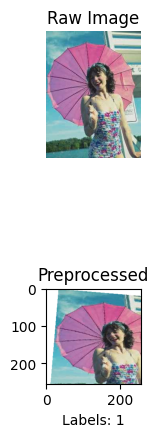

Image ID: 1.jpg
Caption: A couple of men riding horses on top of a green field.


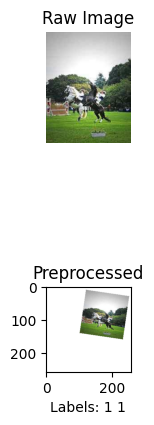

Image ID: 2.jpg
Caption: They are brave for riding in the jungle on those elephants.


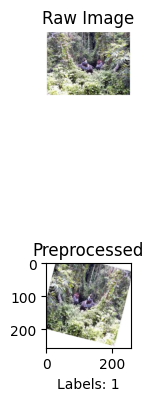

Image ID: 3.jpg
Caption: a black and silver clock tower at an intersection near a tree


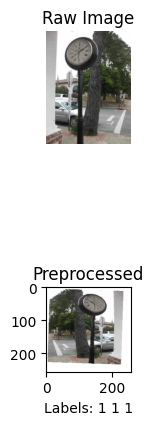

Image ID: 4.jpg
Caption: A train coming to a stop on the tracks out side.


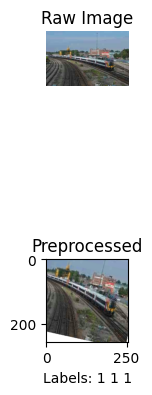

In [67]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

def imshow(img, title=None, caption=None):
    """ Utility function to show an image with title and caption. """
    img = img.numpy().transpose((1, 2, 0))  # Convert from tensor image
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean  # Unnormalize
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    if caption is not None:
        plt.xlabel(caption)
    plt.pause(0.001)  # Pause a bit so that plots are updated

def visualize_dataset_samples(dataset, num_samples=5):
    """ Visualizes samples from the dataset including comparisons between raw and processed images. """
    fig = plt.figure()

    for i in range(num_samples):
        sample = dataset[i]
        print(f"Image ID: {sample['id']}")
        print(f"Caption: {sample['caption']}")

        # Display raw image
        ax = plt.subplot(2, num_samples, i + 1)
        raw_img = Image.open(os.path.join(dataset.image_dir, dataset.dataframe.iloc[i, 0]))
        plt.tight_layout()
        ax.axis('off')
        ax.set_title('Raw Image')
        plt.imshow(raw_img)

        # Display preprocessed image
        ax = plt.subplot(2, num_samples, num_samples + i + 1)
        if 'label' in sample:
            label_str = ' '.join(str(int(l)) for l in sample['label'] if l > 0)  # Assuming label tensor can be summed up like this
        else:
            label_str = "No Labels"
        imshow(sample['img'], title='Preprocessed', caption=f"Labels: {label_str}")
        
        

    plt.show()

# Assuming dataset is already defined and loaded as shown previously
visualize_dataset_samples(dataset)


In [102]:
from torch.nn.utils.rnn import pad_sequence

# Example tokenizer function (you would replace this with your actual tokenizer)
def tokenize_captions(captions, vocab):
    return [torch.tensor([vocab[word] for word in caption.lower().split() if word in vocab]) for caption in captions]

# Simulated vocabulary dictionary
vocab = {'a': 1, 'man': 2, 'in': 3, 'the': 4, 'batting': 5, 'cage': 6, 'practicing': 7, 'his': 8, 'swings': 9}  # etc.

def prepare_captions(captions):
    tokenized = tokenize_captions(captions, vocab)
    padded = pad_sequence(tokenized, batch_first=True, padding_value=0)  # Padding tokens if necessary
    return padded.float()  # Ensure the tensor is of type float


In [83]:
import time
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm.auto import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score

class Model(nn.Module):
    def __init__(self, emb_table, num_classes):
        super(Model, self).__init__()
        self.google_net = models.googlenet(pretrained=True)
        self.google_net.fc = nn.Linear(self.google_net.fc.in_features, 64)
        for param in self.google_net.parameters():
            param.requires_grad = False
        self.google_net.fc.requires_grad = True
        
        self.emb = nn.Embedding(num_embeddings=emb_table.shape[0], embedding_dim=emb_table.shape[1], _weight=torch.from_numpy(emb_table))
        self.emb.weight.requires_grad = False

        self.lstm = nn.LSTM(input_size=emb_table.shape[1], hidden_size=emb_table.shape[1], num_layers=2, batch_first=True, dropout=0.2)
        self.linear = nn.Linear(in_features=emb_table.shape[1] * 2, out_features=64)
        self.classifier = nn.Linear(in_features=128, out_features=num_classes)

    def forward(self, image, caption):
        # Ensure inputs are floats if not already
        image = image.float()
        caption = caption.float()
        with torch.no_grad():
            net_out = self.google_net(image)[0]
        x = self.emb(caption)
        _, (h, c) = self.lstm(x)
        x = torch.cat((h[0, :, :], h[1, :, :]), 1)
        lstm_out = self.linear(x)
        output = self.classifier(torch.cat((net_out, lstm_out), dim=1))
        return output
    
net_model = Model(emb_table, 18).to(device)

In [14]:
def model_size(model):

    cnn_size = 0
    # Iterate over the named parameters of the model
    for name, param in model.named_parameters():
        # Calculate the size of the parameter in megabytes
        param_size = np.prod(list(param.shape)) * 4 / 1e6
        cnn_size += param_size
  
    # Calculate the embedding model size
    embedding_model_path = gensim_api.load('glove-wiki-gigaword-50', return_path=True)
    embedding_size = os.stat(embedding_model_path).st_size / (1024 * 1024)

    print("Model Memory Usage: {:.4f} MB; Pretrained Embeddings: {:.4f} MB".format(cnn_size, embedding_size))
    print("Total required memory: {:.4f} MB".format((cnn_size + embedding_size)))
    if (cnn_size + embedding_size) > 100:
        raise ValueError("Network storage exceeds 100 MB threshold!")


model_size(net_model)

Model Memory Usage: 23.3036 MB; Pretrained Embeddings: 65.9776 MB
Total required memory: 89.2812 MB


In [78]:
def get_metrics(output, label, threshold):
    pred = (output.sigmoid() > threshold).float()
    precision = precision_score(label.cpu().numpy(), pred.cpu().numpy(), average='micro')
    recall = recall_score(label.cpu().numpy(), pred.cpu().numpy(), average='micro')
    f1 = f1_score(label.cpu().numpy(), pred.cpu().numpy(), average='micro')
    return precision, recall, f1


In [105]:
def train_one_epoch(model, dataloader, loss_fn, optimizer, device):
    model.train()
    running_loss, running_precision, running_recall, running_f1 = 0.0, 0.0, 0.0, 0.0
    for data in tqdm(dataloader):
        img = data['img'].to(device).float()  # Ensure tensor is float
        label = data['label'].to(device).float()  # Ensure label is float
        captions = prepare_captions(data['caption'])
        captions = captions.to(device).float()  # Ensure captions are float
        
        optimizer.zero_grad()
        output = model(img, captions)
        loss = loss_fn(output, label)
        loss.backward()
        optimizer.step()

        precision, recall, f1 = get_metrics(output, label, THRESHOLD)
        running_loss += loss.item() * img.size(0)
        running_precision += precision
        running_recall += recall
        running_f1 += f1

    n_samples = len(dataloader.dataset)
    return running_loss / n_samples, running_precision / n_samples, running_recall / n_samples, running_f1 / n_samples

def validate(model, dataloader, loss_fn, device):
    model.eval()
    running_loss, running_precision, running_recall, running_f1 = 0.0, 0.0, 0.0, 0.0
    with torch.no_grad():
        for data in tqdm(dataloader):
            img = data['img'].to(device)
            label = data['label'].to(device)
            captions = prepare_captions(data['caption'])
            captions = captions.to(device)
            
            output = model(img, captions)
            loss = loss_fn(output, label)

            precision, recall, f1 = get_metrics(output, label, THRESHOLD)
            running_loss += loss.item() * img.size(0)
            running_precision += precision
            running_recall += recall
            running_f1 += f1

    n_samples = len(dataloader.dataset)
    return running_loss / n_samples, running_precision / n_samples, running_recall / n_samples, running_f1 / n_samples


In [106]:
def fit(model, train_dataloader, val_dataloader, epochs, loss_fn, optimizer, scheduler, patience=3, device='cuda'):
    start_time = time.time()
    train_stats, val_stats = [], []
    best_val_f1, epochs_no_improve = 0, 0

    for epoch in range(epochs):
        train_loss, train_precision, train_recall, train_f1 = train_one_epoch(model, train_dataloader, loss_fn, optimizer, device)
        val_loss, val_precision, val_recall, val_f1 = validate(model, val_dataloader, loss_fn, device)
        scheduler.step(val_loss)

        train_stats.append((train_loss, train_precision, train_recall, train_f1))
        val_stats.append((val_loss, val_precision, val_recall, val_f1))

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            epochs_no_improve = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f'Early stopping after {epoch+1} epochs.')
            break

        print(f'Epoch {epoch+1}/{epochs}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val F1: {val_f1:.4%}')
    
    duration = time.time() - start_time
    print(f'Training completed in {duration//60:.0f}m {duration%60:.0f}s.')
    return train_stats, val_stats


In [107]:
class FocalLoss(nn.Module):

    def __init__(self, gamma=2, alpha=0.25):
       
        super().__init__()
        # Wraps focal loss around existing loss_fcn()
        self.loss_fcn = nn.BCEWithLogitsLoss()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = 'sum'
        # required to apply FL to each element
        self.loss_fcn.reduction = 'none'

    def forward(self, pred, true):

        # Calculate the loss
        loss = self.loss_fcn(pred, true)
        # Calculate probability from logits
        pred_prob = torch.sigmoid(pred)
        # Calculate the modulating factor
        p_t = true * pred_prob + (1 - true) * (1 - pred_prob)
        # Calculate the alpha factor
        alpha_factor = true * self.alpha + (1 - true) * (1 - self.alpha)
        modulating_factor = (1.0 - p_t) ** self.gamma
        loss *= alpha_factor * modulating_factor

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:  # 'none'
            return loss

In [108]:
optimizer = torch.optim.Adam(net_model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",
    factor=0.5,
    patience=2,
    threshold=0.0001,
    threshold_mode="rel",
    cooldown=0,
    min_lr=0,
    eps=1e-08,
    verbose=False,
)
loss_function = nn.BCEWithLogitsLoss()
# loss_function = FocalLoss()

In [109]:
for data in train_loader:
    print(type(data['img']), data['img'].shape)
    print(type(data['label']), data['label'].shape)
    print(type(data['caption']), data['caption'])  # Here the type might not be a tensor
    break


<class 'torch.Tensor'> torch.Size([32, 3, 256, 256])
<class 'torch.Tensor'> torch.Size([32, 18])
<class 'list'> ['A white and yellow and red bus driving down the road', 'A young person playing with a disc with snow on the ground.', 'A crowd stands on both sides of a sloping path in a city.', 'A team of baseball players playing a game of baseball.', 'A train moves on one of several pairs of tracks.', 'A man in a suit and tie next to some cars.', 'A small model bus sitting under a TV monitor.', 'A young boy holding a cell phone standing in a kitchen.', 'The black and white dog is lying beside a stuffed bear.', 'a baseball player is pitching a ball at a game', "An aerial view of a train station and it's tracks.", 'there is a male skate boarder riding down a ramp', 'A large jetliner flying above an airport with lots of buildings.', 'A fire hydrant in a grassy curb in a parking lot.', 'A woman on skis on a slope holding her ski poles in the air.', 'An assortment of photographs from an orien

In [110]:
num_classes = 18
# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Model(emb_table, num_classes).to(device)
train_stats, val_stats = fit(model, train_loader, val_loader, MAX_EPOCH, loss_function, optimizer, scheduler, device=device)


  0%|          | 0/750 [00:00<?, ?it/s]

RuntimeError: Expected tensor for argument #1 'indices' to have one of the following scalar types: Long, Int; but got torch.FloatTensor instead (while checking arguments for embedding)

NameError: name 'tr_loss' is not defined

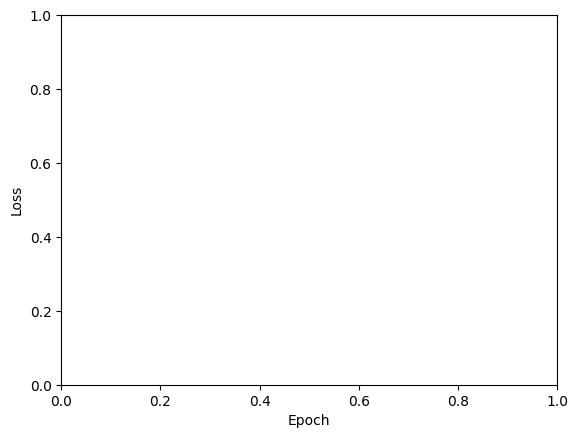

In [22]:
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(tr_loss, label='training_Loss')
plt.plot(vl_loss, label='validation_Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.xlabel("Epoch")
plt.ylabel("Precision")
plt.plot(tr_precision, label='training_Precision')
plt.plot(vl_precision, label='validation_Precision')
plt.legend()
plt.grid(True)
plt.show()

plt.xlabel("Epoch")
plt.ylabel("Recall")
plt.plot(tr_recall, label='training_Recall')
plt.plot(vl_recall, label='validation_Recall')
plt.legend()
plt.grid(True)
plt.show()

plt.xlabel("Epoch")
plt.ylabel("Micro-F1")
plt.plot(tr_f1, label='training_F1')
plt.plot(vl_f1, label='validation_F1')
plt.legend()
plt.grid(True)
plt.show()